# **Goodreads Reviews Extraction & Analysis**  

## **Overview**  
This notebook extracts and analyzes reviews for *Secret History* using Goodreads' GraphQL API. The reviews are saved in JSON format and key insights are computed.  

## **Workflow**  
1. **Fetch Reviews**: Uses `requests` to retrieve reviews via GraphQL API with pagination.  
2. **Store Data**: Saves the extracted reviews as `secret_history.json`.  
3. **Analyze Reviews**: Computes total reviews, average rating, text-based reviews, and the most liked review.  

## **Execution**  
- Scrapes up to 500 pages of reviews.  
- Introduces a `0.5s` delay to prevent rate limits.  
- Outputs review statistics and saves data for further use.

# Goodreads GraphQL API Documentation

## Overview
The Goodreads GraphQL API allows users to fetch book reviews, including details about reviewers, ratings, and review text. This documentation covers the API endpoint used to retrieve reviews for a specific book using its resource ID.

## API Endpoint
**URL:**
```
https://kxbwmqov6jgg3daaamb744ycu4.appsync-api.us-east-1.amazonaws.com/graphql
```
**Method:** `POST`

## Authentication
The API requires an API key, which must be included in the request headers:
```json
{
    "x-api-key": "YOUR_API_KEY"
}
```

## Request Structure

### GraphQL Query
```graphql
query getReviews($filters: BookReviewsFilterInput!, $pagination: PaginationInput) {
    getReviews(filters: $filters, pagination: $pagination) {
        totalCount
        edges {
            node {
                id
                creator {
                    name
                    id: legacyId
                }
                text
                rating
                createdAt
                likeCount
                commentCount
            }
        }
        pageInfo {
            nextPageToken
        }
    }
}
```

### Request Payload (JSON)
```json
{
    "operationName": "getReviews",
    "variables": {
        "filters": {
            "resourceType": "WORK",
            "resourceId": "BOOK_RESOURCE_ID"
        },
        "pagination": {
            "limit": 30
        }
    },
    "query": "GraphQL_QUERY_STRING"
}
```
*Replace `BOOK_RESOURCE_ID` with the actual book resource ID.*

## Response Structure
A successful response returns review details:
```json
{
    "data": {
        "getReviews": {
            "totalCount": 100,
            "edges": [
                {
                    "node": {
                        "id": "review123",
                        "creator": {
                            "name": "John Doe",
                            "id": "user456"
                        },
                        "text": "Great book! Highly recommend.",
                        "rating": 5,
                        "createdAt": "2024-03-01T12:00:00Z",
                        "likeCount": 10,
                        "commentCount": 2
                    }
                }
            ],
            "pageInfo": {
                "nextPageToken": "abc123"
            }
        }
    }
}
```

## Pagination
- The `nextPageToken` in `pageInfo` should be used to fetch additional reviews.
- Modify the request payload to include:
```json
"pagination": {
    "limit": 30,
    "after": "NEXT_PAGE_TOKEN"
}
```
*Replace `NEXT_PAGE_TOKEN` with the actual token from the previous response.*

## Error Handling
If an error occurs, the API returns an error message:
```json
{
    "errors": [
        {
            "message": "Invalid API Key",
            "locations": [{ "line": 1, "column": 2 }],
            "extensions": {
                "code": "UNAUTHORIZED"
            }
        }
    ]
}
```



In [1]:
import requests
import json
import time
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#Using GraphQL API of Goodreads to extract reviews of a book 'Secret History'
def get_query():
    return """
    query getReviews($filters: BookReviewsFilterInput!, $pagination: PaginationInput) {
        getReviews(filters: $filters, pagination: $pagination) {
            totalCount
            edges {
                node {
                    __typename
                    id
                    creator {
                        name
                        id: legacyId
                    }
                    text
                    rating
                    createdAt
                    likeCount
                    commentCount
                }
            }
            pageInfo {
                nextPageToken
            }
        }
    }
    """

def fetch_reviews(url, api_key, book_resource_id, after_token=None):
    headers = {
        "Content-Type": "application/json",
        "x-api-key": api_key
    }
    
    payload = {
        "operationName": "getReviews",
        "variables": {
            "filters": {
                "resourceType": "WORK",
                "resourceId": book_resource_id
            },
            "pagination": {
                "limit": 30
            }
        },
        "query": get_query()
    }
    
    if after_token:
        payload["variables"]["pagination"]["after"] = after_token
    
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching reviews: {e}")
        return None

def scrape_all_reviews(url, api_key, book_resource_id, max_pages=500):
    all_reviews = []
    next_page_token = None
    page_count = 0
    
    while page_count < max_pages:
        print(f"Fetching page {page_count + 1}")
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.5)
        
        response = fetch_reviews(url, api_key, book_resource_id, next_page_token)
        
        if not response or 'data' not in response or not response['data']['getReviews']:
            print("No more reviews or error occurred")
            break
        
        # Extract reviews from this page
        page_reviews = response['data']['getReviews']['edges']
        all_reviews.extend([review['node'] for review in page_reviews])
        
        # Get next page token
        next_page_token = response['data']['getReviews']['pageInfo']['nextPageToken']
        
        # Increment page count
        page_count += 1
        
        # Break if no more pages
        if not next_page_token:
            break
    
    return pd.DataFrame(all_reviews)

def save_reviews_to_json(df, filename='secret_history.json'):
    df.to_json(filename, orient='records', indent=2, force_ascii=False)
    print(f"Saved {len(df)} reviews to {filename}")

def analyze_reviews(df):
    # Basic analysis
    return {
        'total_reviews': len(df),
        'average_rating': df['rating'].mean(),
        'reviews_with_text': df['text'].notna().sum(),
        'most_liked_review': df.loc[df['likeCount'].idxmax()] if not df.empty else None
    }


URL = "https://kxbwmqov6jgg3daaamb744ycu4.appsync-api.us-east-1.amazonaws.com/graphql"
API_KEY = "da2-xpgsdydkbregjhpr6ejzqdhuwy"
BOOK_RESOURCE_ID = "kca://work/amzn1.gr.work.v1.UolPPkYqcwqjqVAWO5T0yQ"

# Scrape reviews
reviews_df = scrape_all_reviews(URL, API_KEY, BOOK_RESOURCE_ID)

# Save reviews
save_reviews_to_json(reviews_df)

# Analyze reviews
analysis = analyze_reviews(reviews_df)
print("\nReview Analysis:")
for key, value in analysis.items():
    print(f"{key}: {value}")

Fetching page 1
Saved 30 reviews to secret_history.json

Review Analysis:
total_reviews: 30
average_rating: 3.7
reviews_with_text: 30
most_liked_review: __typename                                                 Review
id              kca://review:goodreads/amzn1.gr.review:goodrea...
creator         {'name': 'chai (thelibrairie on tiktok!) ♡', '...
text            [Flings myself onto a chaise lounge with a dra...
rating                                                          5
createdAt                                         1551457666761.0
likeCount                                                    3602
commentCount                                                  111
Name: 10, dtype: object


In [3]:
reviews_df.head

<bound method NDFrame.head of    __typename                                                 id  \
0      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
1      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
2      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
3      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
4      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
5      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
6      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
7      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
8      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
9      Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
10     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
11     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
12     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
13     Review  kca

## **Sentiment Analysis of Reviews**  

We argoing to be e analyzing the sentiment of Goodreads reviews using **VADER SentimentIntensityAnalyzer**. Each review's text is processed to generate a **compound sentiment score** ranging from **-1 (negative) to +1 (positive)**. These scores are stored in a new column, allowing us to assess the overall sentiment of the reviews.

In [4]:


# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

reviews_df["sentiment_score"] = reviews_df["text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

print(reviews_df[["text", "sentiment_score"]].head())

                                                text  sentiment_score
0  My original review of this wasn't much of anyt...           0.9992
1  <blockquote>\n  <b>\n    <i>“Beauty is terror....          -0.9485
2  Thank god it's over. I don't think I can surpa...           0.6477
3  The first paragraph of <i>The Secret History</...           0.9985
4  DNF at 70%<br /><br /><b>\n  <i>“If you love o...           0.9748


## **Network Analysis of Goodreads Reviewers**  

We are constructing a **network of frequent reviewers** to analyze relationships based on rating similarity, like counts, and review activity. First, we filter out users with fewer than three reviews to focus on **active reviewers**. Next, we create a **graph representation**, where each node represents a reviewer, and edges are weighted by similarities in their review patterns.  

We then apply **PageRank** to identify the most influential reviewers and calculate **centrality measures** (degree, closeness, and betweenness) to understand their network position. Finally, we visualize the network structure, centrality distributions, and correlations between different centrality metrics. We also compute additional network properties such as density, clustering coefficient, and connectivity.

Top Reviewers by PageRank:
Melissa: PageRank=0.0334, Avg Rating=4.00, Review Count=3, Avg Likes=0.67
Samantha: PageRank=0.0334, Avg Rating=4.00, Review Count=3, Avg Likes=0.67
Jen: PageRank=0.0331, Avg Rating=4.33, Review Count=3, Avg Likes=0.67
Ciara: PageRank=0.0331, Avg Rating=4.33, Review Count=3, Avg Likes=0.67
Megan: PageRank=0.0331, Avg Rating=4.33, Review Count=3, Avg Likes=0.67
Amy: PageRank=0.0330, Avg Rating=4.00, Review Count=3, Avg Likes=1.00
Kate: PageRank=0.0330, Avg Rating=4.00, Review Count=3, Avg Likes=1.00
Jenn: PageRank=0.0330, Avg Rating=4.00, Review Count=3, Avg Likes=0.33
Lindsay: PageRank=0.0327, Avg Rating=4.33, Review Count=3, Avg Likes=0.33
Amanda: PageRank=0.0325, Avg Rating=4.00, Review Count=4, Avg Likes=0.50
Michelle: PageRank=0.0325, Avg Rating=3.67, Review Count=3, Avg Likes=0.33
Sam: PageRank=0.0323, Avg Rating=4.25, Review Count=4, Avg Likes=0.50
Steffi: PageRank=0.0322, Avg Rating=3.67, Review Count=3, Avg Likes=1.33
Sophie: PageRank=0.0320, Avg Rati

C:\Users\ABDUL\AppData\Local\Temp\ipykernel_1572\2409749255.py:117: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd))


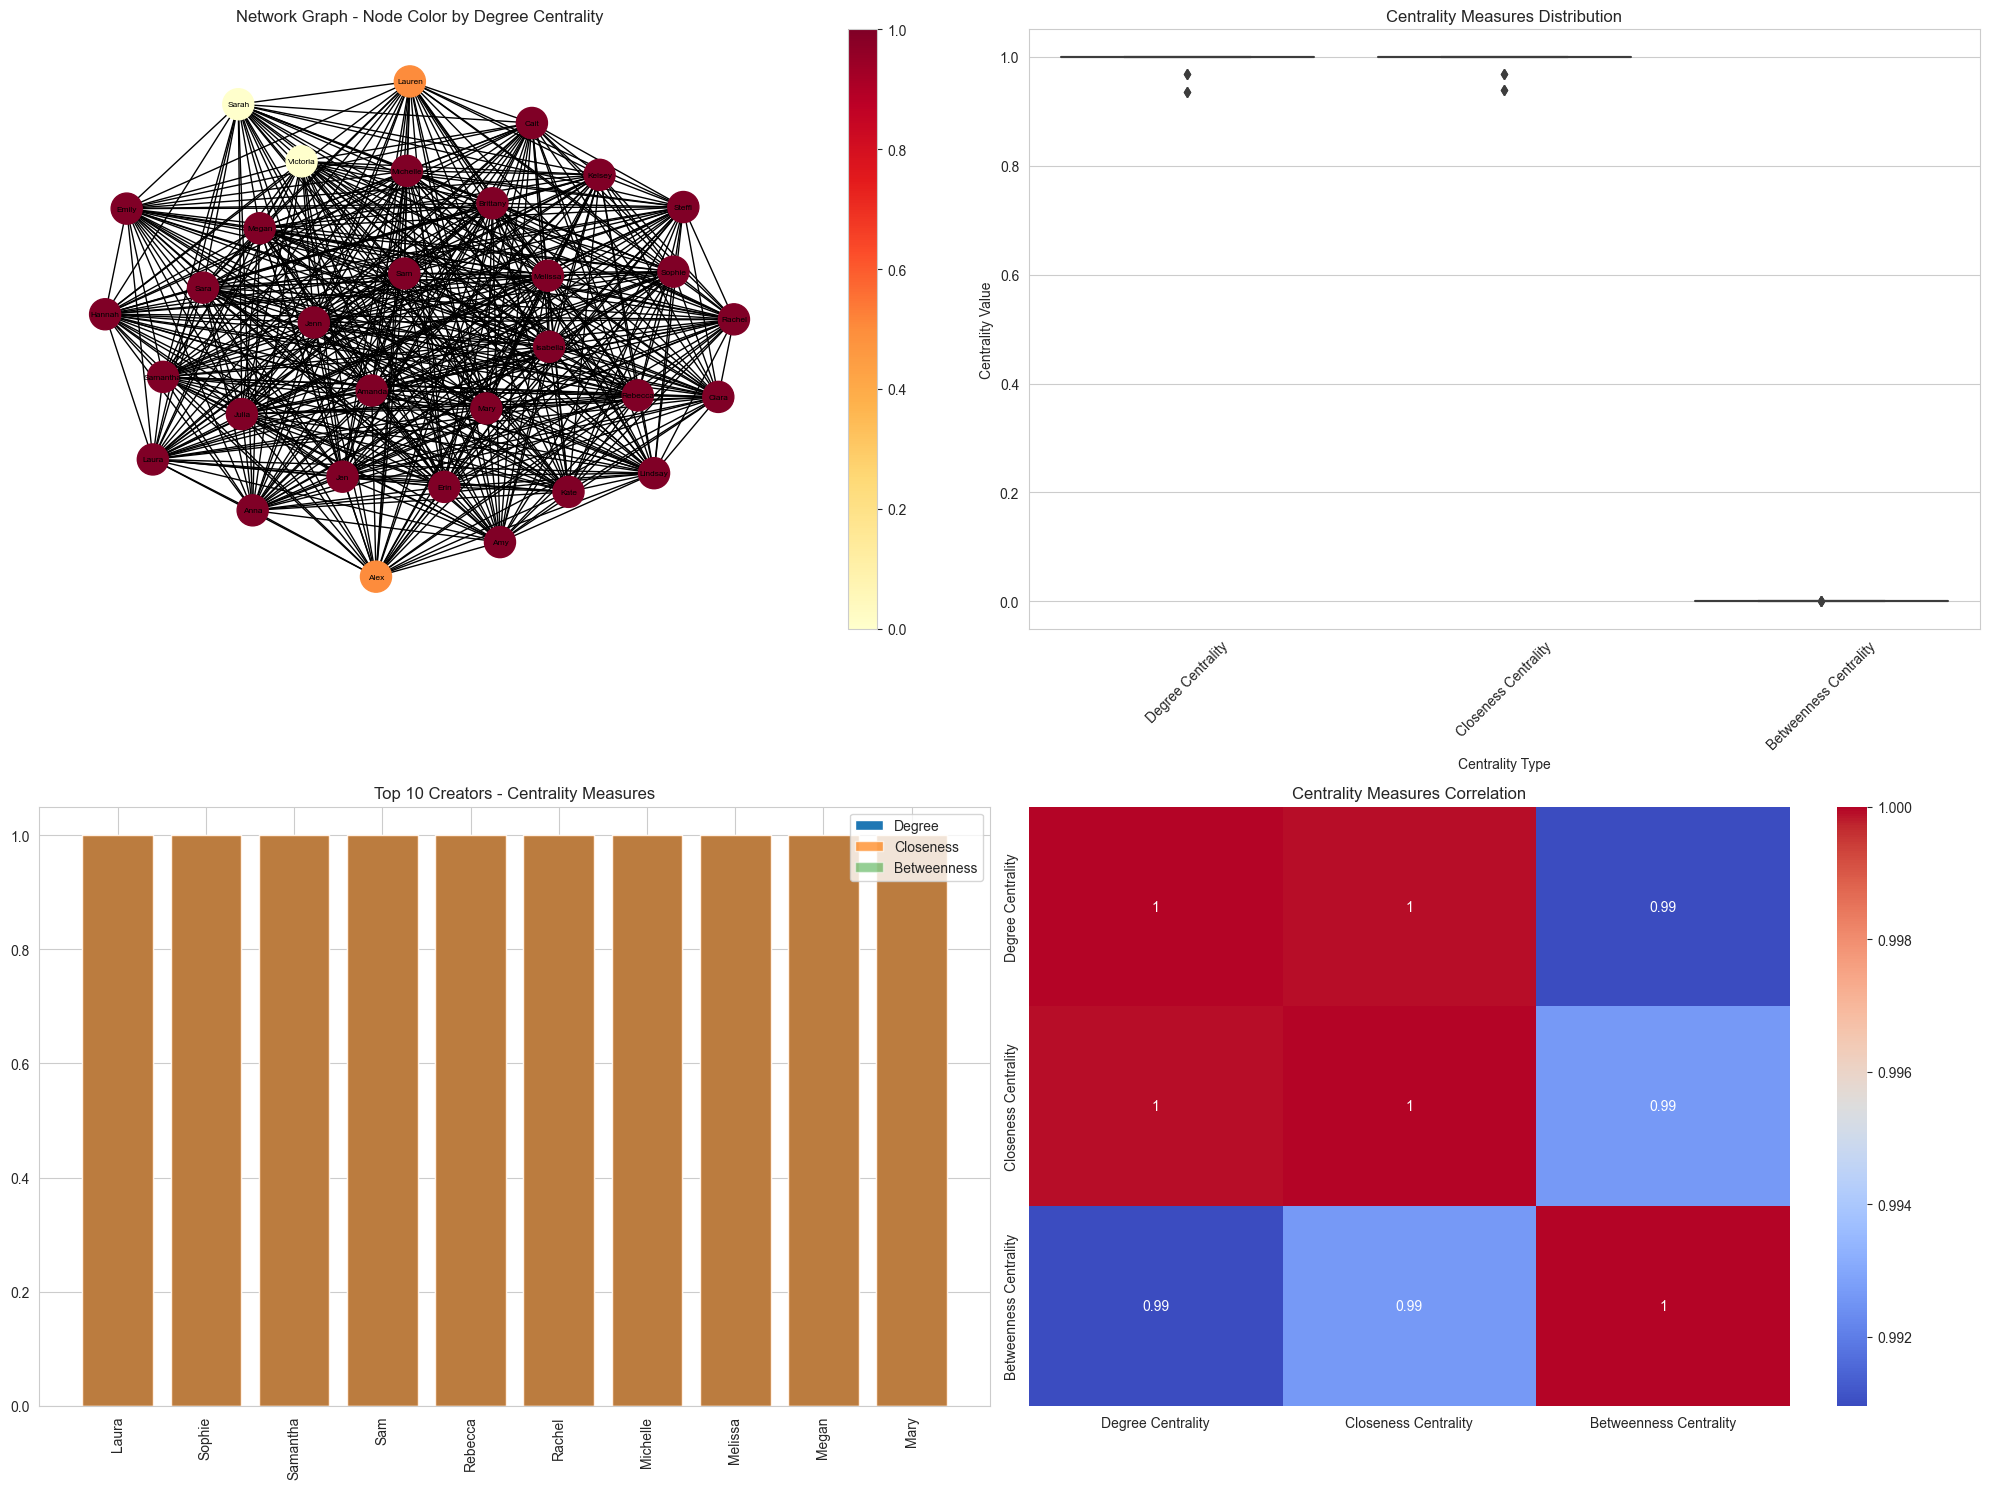


Additional Network Metrics:
Total Nodes: 32
Total Edges: 493
Network Density: 0.9940
Average Clustering Coefficient: 0.9942
Number of Connected Components: 1
Network Diameter: 2
Average Shortest Path Length: 1.0060483870967742


In [127]:


# Filter out very sparse reviewers
reviewer_counts = df['creator'].value_counts()
frequent_reviewers = reviewer_counts[reviewer_counts > 2].index

# Subset of data with frequent reviewers
df_filtered = reviews_df[reviews_df['creator'].isin(frequent_reviewers)]

# 2. Network Creation
def create_review_network(df_filtered):
    # Create graph
    G = nx.Graph()

    # Group by creator
    creator_groups = df_filtered.groupby('creator')

    # Compute aggregated metrics
    creator_metrics = creator_groups.agg({
        'rating': ['mean', 'count'],
        'likeCount': 'mean',
        'sentiment_score': 'mean'
    }).reset_index()
    creator_metrics.columns = ['creator', 'avg_rating', 'review_count', 'avg_likes', 'avg_sentiment']

    # Add nodes with richer attributes
    for _, row in creator_metrics.iterrows():
        G.add_node(row['creator'], 
                   avg_rating=row['avg_rating'],
                   review_count=row['review_count'],
                   avg_likes=row['avg_likes'],
                   avg_sentiment=row['avg_sentiment'])

    # Create edges based on multiple criteria
    creators = list(creator_metrics['creator'])
    for i in range(len(creators)):
        for j in range(i+1, len(creators)):
            creator1 = creators[i]
            creator2 = creators[j]
            
            # More sophisticated similarity calculation
            rating_similarity = 1 - abs(creator_metrics[creator_metrics['creator'] == creator1]['avg_rating'].values[0] - 
                                         creator_metrics[creator_metrics['creator'] == creator2]['avg_rating'].values[0]) / 5
            
            like_similarity = 1 / (1 + abs(creator_metrics[creator_metrics['creator'] == creator1]['avg_likes'].values[0] - 
                                            creator_metrics[creator_metrics['creator'] == creator2]['avg_likes'].values[0]))
            
            review_count_similarity = min(creator_metrics[creator_metrics['creator'] == creator1]['review_count'].values[0],
                                           creator_metrics[creator_metrics['creator'] == creator2]['review_count'].values[0]) / \
                                       max(creator_metrics[creator_metrics['creator'] == creator1]['review_count'].values[0],
                                           creator_metrics[creator_metrics['creator'] == creator2]['review_count'].values[0])
            
            # Combine similarities with weighted approach
            edge_weight = (0.5 * rating_similarity + 
                           0.3 * like_similarity + 
                           0.2 * review_count_similarity)
            
            # Add edge if similarity is significant
            if edge_weight > 0.5:
                G.add_edge(creator1, creator2, weight=edge_weight)
    
    return G, creator_metrics

# Create network
G, creator_metrics = create_review_network(df_filtered)

# 3. PageRank Analysis
pagerank = nx.pagerank(G, weight='weight', alpha=0.85)

# Sort and display top reviewers
top_reviewers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top Reviewers by PageRank:")
for creator, score in top_reviewers:
    metrics = creator_metrics[creator_metrics['creator'] == creator].iloc[0]
    print(f"{creator}: PageRank={score:.4f}, "
          f"Avg Rating={metrics['avg_rating']:.2f}, "
          f"Review Count={metrics['review_count']}, "
          f"Avg Likes={metrics['avg_likes']:.2f}")

# 4. Centrality Measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Combine centrality measures into a DataFrame
centrality_df = pd.DataFrame({
    'Creator': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()]
})

# Sort by degree centrality
centrality_df_sorted = centrality_df.sort_values('Degree Centrality', ascending=False)

# Print top 10 nodes for each centrality measure
print("\nTop 10 Nodes by Centrality Measures:")
print(centrality_df_sorted.head(10))

# 5. Visualization
plt.figure(figsize=(20,15))

# Network Visualization
plt.subplot(2,2,1)
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, 
        node_color=[degree_centrality[node] for node in G.nodes()],
        node_size=500, 
        cmap=plt.cm.YlOrRd, 
        font_size=6)
plt.title("Network Graph - Node Color by Degree Centrality")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd))

# Centrality Comparison Boxplot
plt.subplot(2,2,2)
centrality_melted = centrality_df_sorted.melt(id_vars='Creator', 
                                               var_name='Centrality Type', 
                                               value_name='Centrality Value')
sns.boxplot(x='Centrality Type', y='Centrality Value', data=centrality_melted)
plt.title("Centrality Measures Distribution")
plt.xticks(rotation=45)

# Top Creators by Centrality Measures
plt.subplot(2,2,3)
top_creators = centrality_df_sorted.head(10)
plt.bar(top_creators['Creator'], top_creators['Degree Centrality'], label='Degree')
plt.bar(top_creators['Creator'], top_creators['Closeness Centrality'], label='Closeness', alpha=0.7)
plt.bar(top_creators['Creator'], top_creators['Betweenness Centrality'], label='Betweenness', alpha=0.5)
plt.title("Top 10 Creators - Centrality Measures")
plt.xticks(rotation=90)
plt.legend()

# Correlation of Centrality Measures
plt.subplot(2,2,4)
sns.heatmap(centrality_df_sorted[['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Centrality Measures Correlation")

plt.tight_layout()
plt.show()

# 6. Additional Network Metrics
print("\nAdditional Network Metrics:")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")
print(f"Network Density: {nx.density(G):.4f}")
print(f"Average Clustering Coefficient: {nx.average_clustering(G):.4f}")
print(f"Number of Connected Components: {nx.number_connected_components(G)}")

try:
    print(f"Network Diameter: {nx.diameter(G)}")
    print(f"Average Shortest Path Length: {nx.average_shortest_path_length(G)}")
except nx.NetworkXError as e:
    print(f"Could not calculate diameter or path length: {e}")

In [119]:
print(reviews_df.head())

  __typename                                                 id  \
0     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
1     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
2     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
3     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   
4     Review  kca://review:goodreads/amzn1.gr.review:goodrea...   

                        creator  \
0                      Siobhaan   
1  Brittany’sBoundByBloodBooks    
2                         lexie   
3                    MagretFume   
4                Sadie Hartmann   

                                                text  rating     createdAt  \
0  Turns out I wasn’t in a reading slump I just n...       4  1.726848e+12   
1  <b>Kat Dunn’s Hungerstone sinks its teeth into...       5  1.740096e+12   
2  it’s pub dayyy 💫 i need everyone to read this ...       4  1.734250e+12   
3  This is a great character study of feminine ra...       4  1.740401e+12

## **Sentiment Score Distribution**  

We visualize the **distribution of sentiment scores** using a histogram with kernel density estimation (KDE). This helps us understand the overall sentiment of Goodreads reviews, showing how reviews are spread across positive, negative, and neutral sentiments. The x-axis represents sentiment scores, while the y-axis shows the count of reviews within each score range.

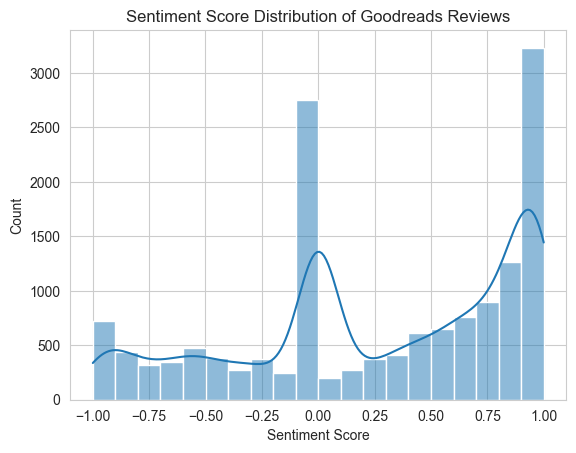

In [147]:

sns.histplot(reviews_df["sentiment_score"], bins=20, kde=True)
plt.title("Sentiment Score Distribution of Goodreads Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

### Sentiment Analysis of Reviews  

We are now categorizing reviews based on their sentiment scores into Positive, Negative, and Neutral categories. This distribution helps us understand the overall sentiment of the reviews and visualize their proportions using a bar chart.

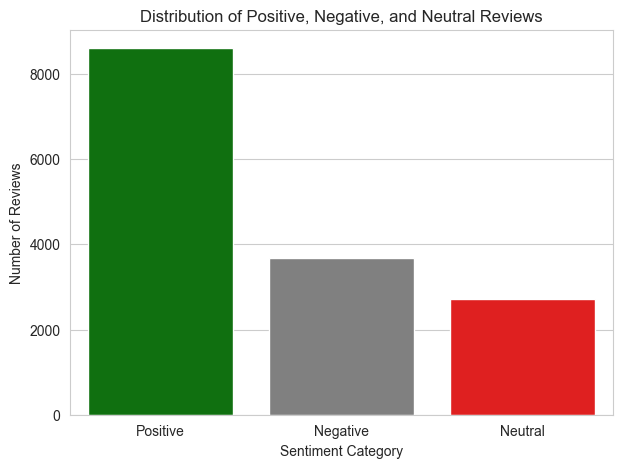

In [158]:
# Create a new column for sentiment category based on sentiment score
reviews_df["sentiment_category"] = reviews_df["sentiment_score"].apply(
    lambda x: "Positive" if x >= 0.05 else "Negative" if x <= -0.05 else "Neutral"
)

# Count sentiment categories
sentiment_counts = reviews_df["sentiment_category"].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(7, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["green", "gray", "red"])
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Positive, Negative, and Neutral Reviews")
plt.show()


## **Top 10 Most Active Reviewers**  

We analyze the most **frequent reviewers** by counting the number of reviews each person has written. The top 10 most active reviewers are displayed using a horizontal bar plot, where the x-axis represents the number of reviews and the y-axis lists the reviewers. This helps identify influential users contributing the most reviews.

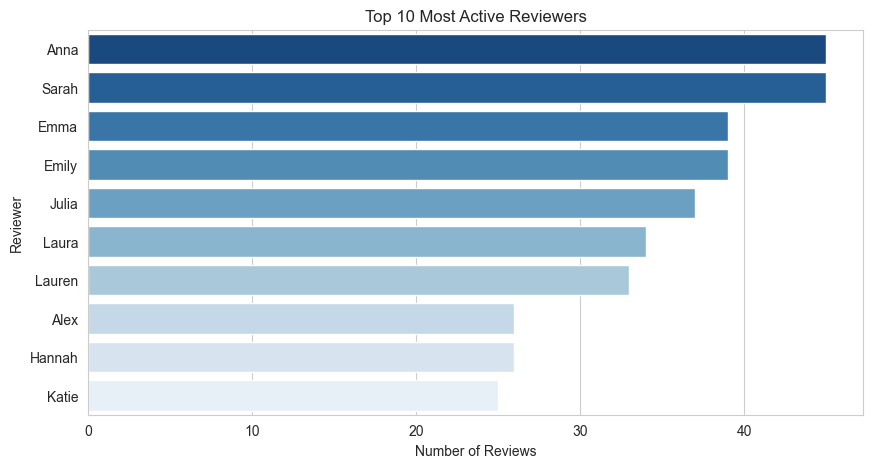

In [143]:


# Count reviews per reviewer
reviewer_df = reviews_df["creator"].apply(lambda x: x["name"]).value_counts().reset_index()

# Rename columns
reviewer_df.columns = ["Reviewer", "Review Count"]

# Get top 10 most active reviewers
reviewer_df = reviewer_df.head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=reviewer_df, x="Review Count", y="Reviewer", palette="Blues_r")
plt.xlabel("Number of Reviews")
plt.ylabel("Reviewer")
plt.title("Top 10 Most Active Reviewers")
plt.show()


## **Rating Distribution Analysis**  

We now analyze the distribution of **ratings** by counting how frequently each rating appears in the dataset. The bar chart provides a clear view of the rating trends, helping us understand user preferences and overall sentiment.

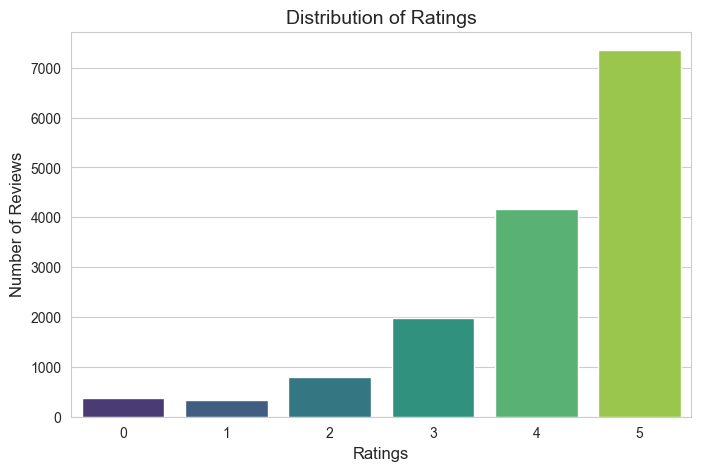

In [155]:

# Set plot style
sns.set_style("whitegrid")

# Count occurrences of each rating
rating_counts = reviews_df["rating"].value_counts().sort_index()

# Plot bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Ratings", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.title("Distribution of Ratings", fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels readable

# Show plot
plt.show()


### **Summary**  

Filtered out inactive reviewers and focused on frequent contributors. Built a reviewer network to identify the most influential users using PageRank and centrality metrics. Analyzed sentiment scores, revealing a general positivity bias. Visualized rating distributions showing dominance of 4 and 5-star reviews. Identified the top 10 most active reviewers and examined their impact on the platform. Goodreads reviews exhibit a strong positive bias, with highly connected reviewer communities influencing ratings and sentiment trends.